# Athritis on heart attack model

## Datenvorverarbeitung:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_score
from collections import defaultdict

# import data
data = pd.read_csv("../data/Arthritis_on_heart_attack.csv",usecols=range(1,15))

# obtain an overview of the data
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3788 entries, 0 to 3787
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   arthritis.type     3788 non-null   object
 1   gender             3788 non-null   object
 2   bmi                3788 non-null   object
 3   diabetes           3788 non-null   object
 4   smoke              3788 non-null   object
 5   age                3788 non-null   object
 6   education          3788 non-null   object
 7   marriage           3788 non-null   object
 8   physical.activity  3788 non-null   object
 9   medical.access     3788 non-null   object
 10  blood.pressure     3788 non-null   object
 11  healthy.diet       3788 non-null   object
 12  covered.health     3788 non-null   object
 13  heart.attack       3788 non-null   object
dtypes: object(14)
memory usage: 414.4+ KB


,arthritis.type,gender,bmi,diabetes,smoke,age,education,marriage,physical.activity,medical.access,blood.pressure,healthy.diet,covered.health,heart.attack
0,Non-arthritis,Male,"(25,80]",No,No,"(50,70]",School,Married,Moderate,Yes,No,Fair,No,No
1,Non-arthritis,Male,"(0,25]",No,No,"(19.9,50]",High.School,Not.married,No,Yes,No,Good,No,No
2,Non-arthritis,Male,"(25,80]",No,Yes,"(50,70]",High.School,Married,No,Yes,Yes,Good,Yes,No
3,Rheumatoid arthritis,Male,"(25,80]",Yes,No,"(50,70]",College,Married,No,Yes,Yes,Poor,Yes,No
4,Non-arthritis,Female,"(25,80]",No,No,"(19.9,50]",High.School,Married,Moderate,No,No,Fair,No,No


In [2]:
# print frequency distributions crosstabs
for col in data:
    data_crosstab = pd.crosstab(data['heart.attack'],
                            data[col], 
                               margins = False)
    print(data_crosstab,"\n")

arthritis.type  Non-arthritis  Rheumatoid arthritis
heart.attack                                       
No                       3454                   224
Yes                        90                    20 

gender        Female  Male
heart.attack              
No              1825  1853
Yes               25    85 

bmi           (0,25]  (25,80]
heart.attack                 
No              1152     2526
Yes               24       86 

diabetes        No  Yes
heart.attack           
No            3378  300
Yes             84   26 

smoke           No   Yes
heart.attack            
No            2073  1605
Yes             31    79 

age           (19.9,50]  (50,70]  (70,81]
heart.attack                             
No                 2316      982      380
Yes                  24       39       47 

education     College  High.School  School
heart.attack                              
No               1733         1541     404
Yes                42           44      24 

marriage      

Die Gruppe der Personen mit Herzinfarkt ist sehr niedrig besetzt mit 110/3678=0.0299075, damit ist der Datensatz moderat bis sehr startk unausgeglichen. 
Dementsprechend kann es sinnvoll sein Methoden wie gewichtetes Sampling,threshhold-moving, oversampling, undersampling oder SMOTE zur Verbesserung der Model Performance anzuwenden.

F1-Score ist ein sinnvoller Scorer für Modelle auf einen unausgeglichenen Datensatz. Da eine leistungsfähige Vorhersage der positiven Klasse 'heart.attack' von hoeherer Relevanz ist sollten hier F0.5-Score und PR AUC bzw. average_precision benutzt werden.

In [3]:
# encode categorical data for modeling
label_dict = defaultdict(LabelEncoder)
data.apply(lambda x: label_dict[x.name].fit_transform(x))

for i in label_dict:
    print(label_dict[i].classes_)
    
# manually setting encoder for healthy.diet for a more reasonable order
label_dict['healthy.diet'].classes_ = ['Good', 'Fair', 'Poor']

# non-binary categories exhibit natural order and are therefore encoded ordinaly 
encoded_data = data.apply(lambda x: label_dict[x.name].transform(x))
encoded_data.head()

['Non-arthritis' 'Rheumatoid arthritis']
['Female' 'Male']
['(0,25]' '(25,80]']
['No' 'Yes']
['No' 'Yes']
['(19.9,50]' '(50,70]' '(70,81]']
['College' 'High.School' 'School']
['Married' 'Not.married']
['High' 'Moderate' 'No']
['No' 'Yes']
['No' 'Yes']
['Fair' 'Good' 'Poor']
['No' 'Yes']
['No' 'Yes']


,arthritis.type,gender,bmi,diabetes,smoke,age,education,marriage,physical.activity,medical.access,blood.pressure,healthy.diet,covered.health,heart.attack
0,0,1,1,0,0,1,2,0,1,1,0,1,0,0
1,0,1,0,0,0,0,1,1,2,1,0,0,0,0
2,0,1,1,0,1,1,1,0,2,1,1,0,1,0
3,1,1,1,1,0,1,0,0,2,1,1,2,1,0
4,0,0,1,0,0,0,1,0,1,0,0,1,0,0


In [4]:
from sklearn.feature_selection import chi2

chi2(encoded_data.loc[:, encoded_data.columns != 'heart.attack'],encoded_data[['heart.attack']])

(array([2.42425701e+01, 1.50973112e+01, 1.39884606e+00, 2.97382272e+01,
        1.90789571e+01, 1.16714793e+02, 6.47822113e+00, 1.05688353e-01,
        1.39044315e+00, 1.27303002e+00, 6.88725679e+01, 9.41227337e-01,
        3.64724397e+00]),
 array([8.49340896e-07, 1.02108622e-04, 2.36916873e-01, 4.94500196e-08,
        1.25420175e-05, 3.31464790e-27, 1.09204222e-02, 7.45107318e-01,
        2.38330276e-01, 2.59199018e-01, 1.05035733e-16, 3.31962402e-01,
        5.61620742e-02]))

Zum testen der Abhaengigkeit zwischen kategorischen Variablen kann der Chi-Quadrat-Test angewandt, Merkmalsinteraktionen werden bei diesem Test ignoriert. Wenn man beim p-Wert von einem Signifikanzniveau von 0.05 ausgeht, wuerde man sich fuer die Variablen 'arthritis.type', 'gender', 'diabetes', 'smoke', 'age', 'education', 'blood.pressure'. Wir nutzen dennoch erstmal den gesamten Datensatz zur Modellierung.

Daraus kann man schließen, dass die gegebenen Merkmale geeignet sind um einen Herzinfarkt zu prognostizieren.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

y = encoded_data['heart.attack']
X = encoded_data.drop('heart.attack',axis=1)

# stratified train test split over heart.attack 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=0)

## Logistische Regressions Modellierung

Zunaechst wird ein logistisches Regressionsmodell genutzt, weil es für binäre Klassifizierung geeignet ist und in der Lage ist durch eine interne Gewichtung ein relativ gutes Model auf dem unausgeglichenen Daten zu generieren. Durch den l1-Regulator werden Koeffizienten von nicht-relevanten Merkmalen gegen Null reduziert und der l2-Regulator verminder overfitting.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.metrics import fbeta_score, make_scorer
f05_scorer = make_scorer(fbeta_score, beta=0.5)

scorer = f05_scorer

# create naive model with 'balanced' class weight
lr_balanced = LogisticRegression(class_weight='balanced')

scores = cross_val_score(lr_balanced, X_train, y_train, scoring=scorer, cv=5, n_jobs=1)

print('F0.5-Score: %.3f' % (mean(scores)))

F0.5-Score: 0.100


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best F0.5-Score score :  0.2347449042213306
Best class weights :  {'class_weight': {0: 0.1442713567839196, 1: 0.8557286432160804}}


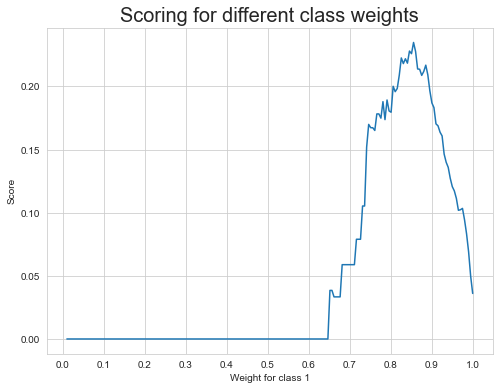

In [7]:
# optimize class weights
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression()
# Setting the range for class weights
weights = np.linspace(0.0,0.99,200)
# Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

# Fitting grid search to the train data with 5 folds
lr_weight_gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring=scorer, 
                          verbose=2).fit(X_train, y_train)
                          # Ploting the score for different values of weight
                          
sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
weigh_data = pd.DataFrame({ 'score': lr_weight_gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(x=weigh_data['weight'],y= weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('Score')
plt.xticks(np.linspace(0,1,11))
plt.title('Scoring for different class weights', fontsize=20)

lr_weighted = lr_weight_gridsearch.best_estimator_

print('Best F0.5-Score score : ', lr_weight_gridsearch.best_score_)
print('Best class weights : ', lr_weight_gridsearch.best_params_)

In [14]:
# optimize regulization parameters
regulizer_param_grid = {'C' : (np.arange(0.05,1,0.05)),
            'l1_ratio': (np.arange(0,1,0.05)) }

lr_regulizer_gridsearch = GridSearchCV(estimator= lr_weighted.set_params(solver='saga',penalty='elasticnet'), 
                          param_grid= regulizer_param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring=scorer, 
                          verbose=2).fit(X_train, y_train)

print(lr_regulizer_gridsearch.best_estimator_)

Fitting 5 folds for each of 380 candidates, totalling 1900 fits
LogisticRegression(C=0.6500000000000001,
                   class_weight={0: 0.1442713567839196, 1: 0.8557286432160804},
                   l1_ratio=0.5, penalty='elasticnet', solver='saga')


In [16]:
# retrain final model on whole training data set
lr_model = lr_regulizer_gridsearch.best_estimator_.fit(X_train,y_train)

# report on final model
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred)
print('F0.5-Score score : ', fbeta_score(y_test, y_pred,beta=0.5))

F0.5-Score score :  0.3076923076923077
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       736
           1       0.30      0.36      0.33        22

    accuracy                           0.96       758
   macro avg       0.64      0.67      0.65       758
weighted avg       0.96      0.96      0.96       758



col_0,0,1
heart.attack,,
0,717,19
1,14,8


PR-AUC : 0.197
Best Threshold=0.535635, F-Score=0.400


c:\Users\David\Documents\Jobs\2021NovemberNachBsc\angenommen\Ingef\PropensityScoreMatching\env\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


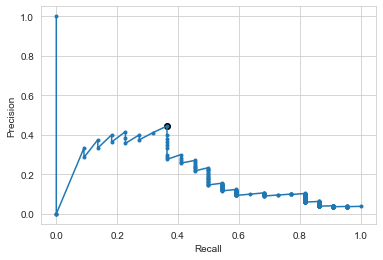

In [19]:
# optimize classification threshold

# get prediction probabilities for scoring
pos_proba = lr_model.predict_proba(X_test)[:,1]

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, pos_proba)

auc_precision_recall = auc(recall, precision)

print('PR-AUC : %.3f' % (auc_precision_recall))

fscore = (2 * precision * recall) / (precision + recall)
idx = np.nanargmax(fscore)

print('Best Threshold = %f, F-Score = %.3f' % (thresholds[idx], fscore[idx]))

# plot Precision Recall Curve with 'optimal' threshold
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best')

In [20]:
# report on final model with optimized threshold
y_pred_thresh = (pos_proba >thresholds[idx]).astype(bool)
print(classification_report(y_test,y_pred_thresh))
pd.crosstab(y_test,y_pred_thresh)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       736
           1       0.41      0.32      0.36        22

    accuracy                           0.97       758
   macro avg       0.70      0.65      0.67       758
weighted avg       0.96      0.97      0.96       758



col_0,False,True
heart.attack,,
0,726,10
1,15,7


In [22]:
X_train_sub = X_train[['arthritis.type', 'gender', 'diabetes', 'smoke', 'age', 'education', 'blood.pressure']]
X_test_sub = X_test[['arthritis.type', 'gender', 'diabetes', 'smoke', 'age', 'education', 'blood.pressure']]

# optimize weight
# Setting the range for class weights
weights = np.linspace(0.0,0.99,200)
# Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}
# Fitting grid search to the train data with 5 folds
lr_weight_gridsearch_sub = GridSearchCV(estimator= LogisticRegression(), 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring=scorer, 
                          verbose=2).fit(X_train_sub, y_train)
                          # Ploting the score for different values of weight
                          
lr_weighted_sub = lr_weight_gridsearch.best_estimator_

# optimize regulization parameters
regulizer_param_grid = {'C' : (np.arange(0.05,1,0.05)),
            'l1_ratio': (np.arange(0,0.95,0.05)) }

lr_regulizer_gridsearch_sub = GridSearchCV(estimator= lr_weighted_sub.set_params(solver='saga',penalty='elasticnet'), 
                          param_grid= regulizer_param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring=scorer, 
                          verbose=2).fit(X_train_sub, y_train)

# get final logistical regression model
lr_model_sub = lr_regulizer_gridsearch.best_estimator_
lr_model_sub.fit(X_train_sub,y_train)

# get prediction probabilities for scoring
pos_proba_sub = lr_model_sub.predict_proba(X_test_sub)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, pos_proba_sub)

# optimize threshold
fscore = (2 * precision * recall) / (precision + recall)
idx = np.nanargmax(fscore)
y_pred_thresh_sub = (lr_model_sub.predict_proba(X_test_sub)[:,1]> thresholds[idx] ).astype(bool)

# report final sub model
print(classification_report(y_test,y_pred_thresh_sub))
print(pd.crosstab(y_test,y_pred_thresh_sub))
auc_precision_recall = auc(recall, precision)
print('PR-AUC : %.3f' % (auc_precision_recall))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 361 candidates, totalling 1805 fits
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       736
           1       0.25      0.36      0.30        22

    accuracy                           0.95       758
   macro avg       0.62      0.67      0.64       758
weighted avg       0.96      0.95      0.95       758

PR-AUC : 0.190


c:\Users\David\Documents\Jobs\2021NovemberNachBsc\angenommen\Ingef\PropensityScoreMatching\env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


## Random Forest Modellierung
Als zweites wird ein Random Forest Klassifizierer angewandt. Hierbei ist wieder eine Kalibrierung der Gewichte möglich um den unausgeglichenen Datensatz besser zu modellieren.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold 

rf_model = RandomForestClassifier(n_estimators=1000)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(rf_model, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)

print('F0.5 Score: %.3f (%.3f)' % (mean(scores), std(scores)))

F0.5 Score: 0.103 (0.151)


In [29]:
# build random forest classifier with undersampling on complete data set
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

rf_model = BalancedRandomForestClassifier(n_estimators=1000)

rf_model.fit(X_train,y_train)

y_rf_pred = rf_model.predict(X_test)

print(classification_report(y_test,y_rf_pred))
print(pd.crosstab(y_test,y_rf_pred))

rf_pos_proba = rf_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, rf_pos_proba)
auc_precision_recall = auc(recall, precision)
print('PR-AUC : %.3f' % (auc_precision_recall))


              precision    recall  f1-score   support

           0       0.99      0.74      0.84       736
           1       0.08      0.73      0.14        22

    accuracy                           0.74       758
   macro avg       0.53      0.73      0.49       758
weighted avg       0.96      0.74      0.82       758

col_0           0    1
heart.attack          
0             542  194
1               6   16
PR-AUC : 0.104


In [31]:
# optimize threshold
fscore = (2 * precision * recall) / (precision + recall)
idx = np.nanargmax(fscore)
print("Optimized threshold : ",thresholds[idx])
y_pred_thresh = (rf_model.predict_proba(X_test)[:,1]> thresholds[idx] ).astype(bool)
print(classification_report(y_test,y_pred_thresh))
pd.crosstab(y_test,y_pred_thresh)

c:\Users\David\Documents\Jobs\2021NovemberNachBsc\angenommen\Ingef\PropensityScoreMatching\env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Optimized threshold :  0.7986166666666666
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       736
           1       0.17      0.36      0.23        22

    accuracy                           0.93       758
   macro avg       0.58      0.66      0.60       758
weighted avg       0.96      0.93      0.94       758



col_0,False,True
heart.attack,,
0,697,39
1,14,8


In [25]:
rf_model_sub = BalancedRandomForestClassifier(n_estimators=1000)

rf_model_sub.fit(X_train_sub,y_train)

y_rf_pred = rf_model_sub.predict(X_test_sub)

print(classification_report(y_test,y_rf_pred))
print(pd.crosstab(y_test,y_rf_pred))

rf_pos_proba_sub = rf_model_sub.predict_proba(X_test_sub)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, rf_pos_proba_sub)
auc_precision_recall = auc(recall, precision)
print('PR-AUC : %.3f' % (auc_precision_recall))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       736
           1       0.09      0.77      0.16        22

    accuracy                           0.76       758
   macro avg       0.54      0.77      0.51       758
weighted avg       0.96      0.76      0.84       758

col_0           0    1
heart.attack          
0             561  175
1               5   17
PR-AUC : 0.133


In [28]:
# optimize threshold
fscore = (2 * precision * recall) / (precision + recall)
idx = np.nanargmax(fscore)
print("Optimized threshold : ",thresholds[idx])
y_pred_thresh_sub = (rf_model_sub.predict_proba(X_test_sub)[:,1]> thresholds[idx] ).astype(bool)
print(classification_report(y_test,y_pred_thresh_sub))
pd.crosstab(y_test,y_pred_thresh_sub)

c:\Users\David\Documents\Jobs\2021NovemberNachBsc\angenommen\Ingef\PropensityScoreMatching\env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Optimized threshold :  0.8811880952380953
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       736
           1       0.24      0.27      0.26        22

    accuracy                           0.95       758
   macro avg       0.61      0.62      0.62       758
weighted avg       0.96      0.95      0.96       758



col_0,False,True
heart.attack,,
0,717,19
1,16,6


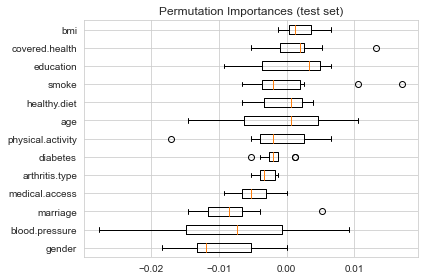

In [35]:
from sklearn.inspection import permutation_importance
# calculate permutation importance of random forest
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [38]:
import shap  
# explain the model's predictions using SHAP
explainer = shap.Explainer(rf_model)
shap_values = explainer.shap_values(X_test)


# create shap bar plot for a single instance
shap.bar_plot(shap_values= shap_values[1][0], features = X_test.iloc[0], feature_names= X_test.columns)

# create shap summary plot
shap.summary_plot(shap_values= shap_values[1], features = X_test, feature_names= X_test.columns)

ModuleNotFoundError: No module named 'shap'